<a href="https://colab.research.google.com/github/saikrishna-pallerla/iMaterialist_2018_Challenge/blob/master/Kaggle_iMat_2018_Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
''' Kaggle Challenge
https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/data
'''

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"

##Change directory
%cd /content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5

**Step 0:Downloading image files from Kaggle**

In [ ]:
##Download data
!kaggle competitions download -c imaterialist-challenge-fashion-2018

  0% 0.00/716k [00:00<?, ?B/s]
100% 716k/716k [00:00<00:00, 46.6MB/s]
  0% 0.00/330k [00:00<?, ?B/s]
100% 330k/330k [00:00<00:00, 44.6MB/s]
  0% 0.00/496k [00:00<?, ?B/s]
100% 496k/496k [00:00<00:00, 33.5MB/s]
 86% 25.0M/28.9M [00:00<00:00, 33.0MB/s]
100% 28.9M/28.9M [00:00<00:00, 49.2MB/s]


In [ ]:
!ls

sample_submission.csv.zip  test.json.zip  train.json.zip  validation.json.zip


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  test.json.zip
  inflating: test.json               

Archive:  validation.json.zip
  inflating: validation.json         

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  train.json.zip
  inflating: train.json              

4 archives were successfully processed.


In [ ]:
!ls

sample_submission.csv  test.json  train.json  validation.json


Fast AI - DL_Lesson1

**Step1 : Setting up directories and downloading images**

In [ ]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image 
import numpy as np
import pandas as pd
import os
import ast
import time as time
import warnings
import shutil
from sklearn.metrics import fbeta_score
warnings.filterwarnings("ignore")

bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

kaggle_dir = '/content/gdrive/My Drive/Kaggle'
data_dir = kaggle_dir+'/iMaterialist_Challenge_FGVC5'
curr_dir="/content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5/"

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"

##Change directory
%cd /content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5

/content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5


In [ ]:
#Creating directories for train,validation and test
folders=['train_data','validation_data','test_data']
train_dir,valid_dir,test_dir=[curr_dir+"/"+str(i) for i in folders]

def create_dirs(path,dirs):
  [os.mkdir(path+'/'+dir) for dir in dirs if not os.path.exists(path+'/'+dir)]
create_dirs(curr_dir,folders)

In [ ]:
##Functions to extract only sample data to work on 
def process_raw_data(path,filename,sample_frac,save=False):
  with open(path+filename+'.json') as f:
    data=json.load(f)
  data_ann=data['annotations']
  data_ann=pd.DataFrame(data_ann)
  data_url=data['images']
  data_url=pd.DataFrame(data_url)

  data_final=pd.merge(data_url,data_ann,how='inner',on='imageId')
  if save==True:
    data_final.to_csv(path+filename+'_labels_all.csv',index=False)
  print('Total records in {} is {}'.format(filename,len(data_final)))

  data_dict=data_final.to_dict('records')
  
  if sample_frac<1:
    frac=int(len(data_ann)*sample_frac)
    print('Sampling {} records in {}'.format(frac,filename))
    random.seed(2)
    sample_ids=random.sample(list(data_ann.index),frac)
    data_ann_f=data_ann.iloc[sample_ids]
    data_final=data_final.loc[data_final['imageId'].isin(data_ann_f['imageId'])]
    if save==True:
      data_final.to_csv(path+filename+'_labels.csv',index=False)
    data_dict=data_final.to_dict('records')
    print('Sampled records in {} is {}'.format(filename,len(data_final)))
  return data_final,data_dict

def process_test_data(path,filename,sample_frac,save=False):
  with open(path+filename+'.json') as f:
    data=json.load(f)
  data_url=data['images']
  data_url=pd.DataFrame(data_url)

  if save==True:
    data_url.to_csv(path+filename+'_labels_all.csv',index=False)
  print('Total records in {} is {}'.format(filename,len(data_url)))

  data_dict=data_url.to_dict('records')
  
  if sample_frac<1:
    frac=int(len(data_url)*sample_frac)
    print('Sampling {} records in {}'.format(frac,filename))
    random.seed(2)
    sample_ids=random.sample(list(data_url.index),frac)
    data_url=data_url.iloc[sample_ids]
    if save==True:
      data_url.to_csv(path+filename+'_labels.csv',index=False)
    data_dict=data_url.to_dict('records')
    print('Sampled records in {} is {}'.format(filename,len(data_final)))
  return data_url,data_dict

In [ ]:
## Functions to download train,validation and test images
def download_valid_images(img):
  out_path='/content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5/validation_data/'
  imgurl,imgid=img['url'],img['imageId']
  img_data = requests.get(imgurl).content
  with open(out_path+'/'+str(imgid)+".jpg", 'wb') as handler:
    handler.write(img_data)

def download_train_images(img):
  out_path='/content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5/train_data_final_all_v4/'
  imgurl,imgid=img['url'],img['imageId']
  img_data = requests.get(imgurl).content
  with open(out_path+str(imgid)+".jpg", 'wb') as handler:
    handler.write(img_data)

def download_test_images(img):
  out_path='/content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5/test_data/'
  imgurl,imgid=img['url'],img['imageId']
  img_data = requests.get(imgurl).content
  with open(out_path+'/'+str(imgid)+".jpg", 'wb') as handler:
    handler.write(img_data)

def show_image(path,filename): 
  # Read image 
  img = Image.open(path+filename)     
  # Output Images 
  return img

In [ ]:
validation_labels,validation_dict=process_raw_data(curr_dir,'validation',1)
train_labels,train_dict=process_raw_data(curr_dir,'train',0.2)

Total records in validation is 9897
Total records in train is 1014544
Sampling 202908 records in train
Sampled records in train is 202908


In [ ]:
test_labels,test_dict=process_test_data(curr_dir,'test',sample_frac=1)

Total records in test is 39706


In [ ]:
#Run multiprocessing to download "validation" images
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
pool = Pool(processes=12)
print('Length of validation images is {}'.format(len(validation_labels)))
with tqdm(total=len(validation_labels)) as progress_bar:
  for _ in pool.imap_unordered(download_valid_images,validation_dict):
    progress_bar.update(1)

  0%|          | 0/9897 [00:00<?, ?it/s]

Length of validation images is 9897


100%|██████████| 9897/9897 [05:59<00:00, 27.55it/s]


In [ ]:
#Run multiprocessing to download "train" images
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
pool = Pool(processes=12)
print('Length of train images is {}'.format(len(train_labels)))
with tqdm(total=len(train_labels)) as progress_bar:
  for _ in pool.imap_unordered(download_train_images,train_dict):
    progress_bar.update(1)

  0%|          | 0/202908 [00:00<?, ?it/s]

Length of train images is 202908


100%|██████████| 202908/202908 [2:15:42<00:00, 24.92it/s]


In [ ]:
#Run multiprocessing to download "test" images
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
pool = Pool(processes=12)
print('Length of test images is {}'.format(len(test_labels)))
with tqdm(total=len(test_labels)) as progress_bar:
  for _ in pool.imap_unordered(download_test_images,test_dict):
    progress_bar.update(1)

  0%|          | 0/39706 [00:00<?, ?it/s]

Length of test images is 39706


100%|██████████| 39706/39706 [24:00<00:00, 27.56it/s]


In [ ]:
##Add 'valid_' as prefix to each image file in validation folder
source=curr_dir+'validation_data/'
for filename in os.listdir(source):
  src=source+filename
  dest=source+'valid_'+filename
  os.rename(src,dest)
  
##Add 'test_' as prefix to each image file in test folder
source=curr_dir+'test_data/'
for filename in os.listdir(source):
  src=source+filename
  dest=source+'test_'+filename
  os.rename(src,dest)
  

**Step 2: Image Data Processing**

In [ ]:
train_labels=pd.read_csv(curr_dir+'train_labels.csv')
validation_labels=pd.read_csv(curr_dir+'validation_labels_all.csv')
test_labels=pd.read_csv(curr_dir+'test_labels_all.csv')

validation_labels['imageId1']='valid_'+validation_labels['imageId'].astype(str)
validation_labels.drop(columns='imageId',inplace=True)
validation_labels.rename(columns={'imageId1':'imageId'},inplace=True)

train_dict=train_labels.to_dict('records')
validation_dict=validation_labels.to_dict('records')

train_labels['is_valid']=0
validation_labels['is_valid']=1
all_labels=pd.concat([train_labels,validation_labels],ignore_index=True)

all_labels['filename']='train_data_final_all/'+all_labels['imageId'].astype(str)+'.jpg'
all_labels.loc[all_labels['is_valid']==1,'filename']='validation_data/'+all_labels['imageId'].astype(str)+'.jpg'
all_labels['labelId']=all_labels['labelId'].str.replace(']',"")
all_labels['labelId']=all_labels['labelId'].str.replace('[',"")
all_labels['labelId']=all_labels['labelId'].str.replace(" ","")
all_labels['labelId']=all_labels['labelId'].apply(lambda x:x.replace("'",""))
all_labels_final=all_labels[['filename','labelId','is_valid']]

In [ ]:
##Working on a sample data for train and validation
sample_train_labels2=pd.DataFrame()
sample_train_labels3=pd.DataFrame()
sample_train_labels4=pd.DataFrame()
sample_train_labels1=train_labels[0:7000].reset_index(drop=True)
sample_train_labels2=train_labels[35000:38000].reset_index(drop=True)
sample_train_labels3=train_labels[52000:54000].reset_index(drop=True)
sample_train_labels4=train_labels[69000:70000].reset_index(drop=True)
sample_train_labels=pd.concat([sample_train_labels1,sample_train_labels2,sample_train_labels3,sample_train_labels4],ignore_index=True)
sample_valid_labels=validation_labels[0:1500].reset_index(drop=True)

sample_train_dict=sample_train_labels.to_dict('records')
sample_validation_dict=sample_valid_labels.to_dict('records')

sample_labels=pd.concat([sample_train_labels,sample_valid_labels],ignore_index=True)

sample_labels['filename']='train_data_final_all/'+sample_labels['imageId'].astype(str)+'.jpg'
sample_labels.loc[sample_labels['is_valid']==1,'filename']='validation_data/'+sample_labels['imageId'].astype(str)+'.jpg'
sample_labels['labelId']=sample_labels['labelId'].str.replace(']',"")
sample_labels['labelId']=sample_labels['labelId'].str.replace('[',"")
sample_labels['labelId']=sample_labels['labelId'].str.replace(" ","")
sample_labels['labelId']=sample_labels['labelId'].apply(lambda x:x.replace("'",""))
sample_labels_final=sample_labels[['filename','labelId','is_valid']]

a=[]
for j in sample_labels_final.loc[sample_labels_final['is_valid']==0,'labelId']:
  for k in j.split(','):
    a.append(k)
len(set(a))

228

In [ ]:
#Run multiprocessing to download "train" images
# os.mkdir(curr_dir+'train_data_final_all/')

import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
pool = Pool(processes=12)
print('Length of train images is {}'.format(len(sample_train_labels)))
with tqdm(total=len(sample_train_labels)) as progress_bar:
  for _ in pool.imap_unordered(download_train_images,sample_train_dict):
    progress_bar.update(1)

  0%|          | 0/13000 [00:00<?, ?it/s]

Length of train images is 13000


100%|██████████| 13000/13000 [04:26<00:00, 48.72it/s]


**Step 3: Using Resnet50 architecture with pretrained weights on 128*128 size images**

In [ ]:
src=(ImageList.from_df(sample_labels_final,path=curr_dir,cols='filename').split_from_df('is_valid').label_from_df(cols='labelId',label_delim=','))
tfms=get_transforms(do_flip=True)

In [ ]:
data=(src.transform(tfms,size=128).databunch(bs=256).normalize(imagenet_stats))

In [ ]:
len(data.train_ds.items),len(data.valid_ds.items),len(set(data.classes))

(13000, 1500, 228)

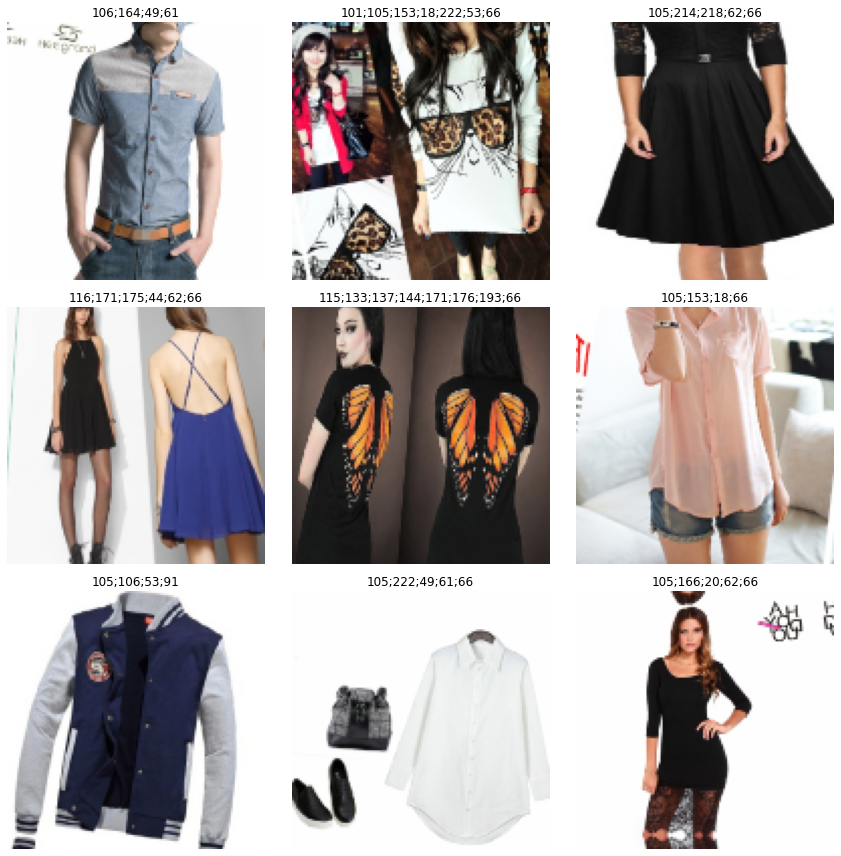

In [ ]:
data.show_batch(rows=3)

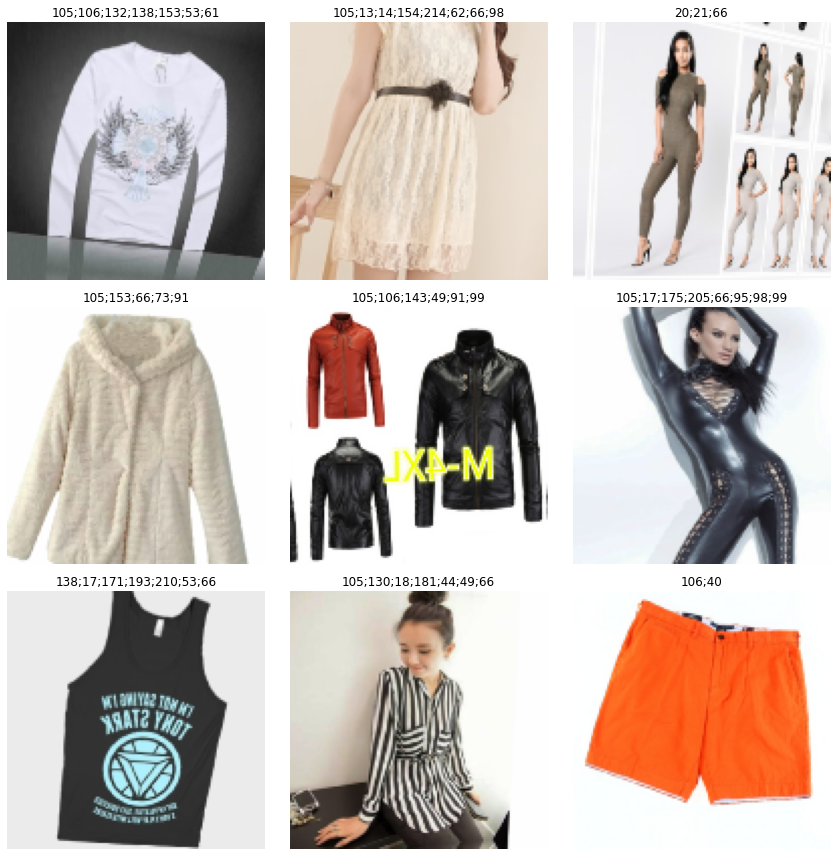

In [ ]:
data.show_batch(DatasetType='valid_ds',rows=3)

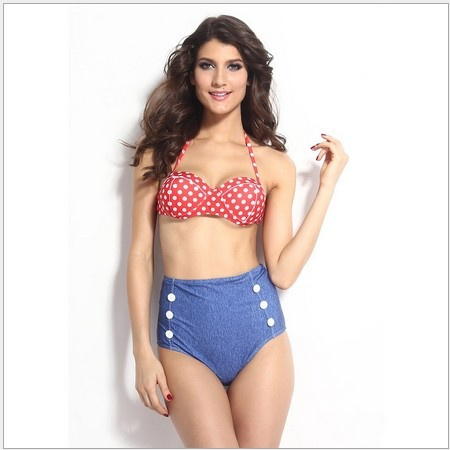

In [ ]:
show_image(curr_dir,filename='train_data_final_all/12.jpg')

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2,beta=1)
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score])

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


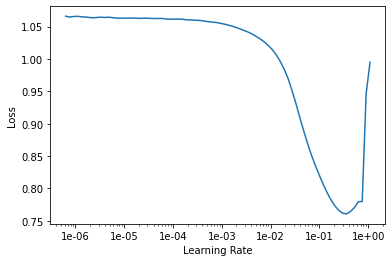

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.06
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.332535,0.176593,0.957942,0.393614,08:41
1,0.149259,0.104480,0.966439,0.447636,04:33
2,0.096313,0.095613,0.967213,0.480956,04:31
3,0.077323,0.095119,0.968322,0.480373,04:33
4,0.069508,0.095114,0.968339,0.483122,04:31


In [ ]:
learn.save('phase1-128-s1-rn50')

**Step 4: Fine tune the model weights for all layer groups on 128*128 size images**

In [ ]:
##Fine tune the model
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


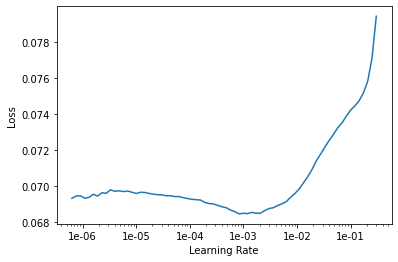

In [ ]:
learn.recorder.plot()

In [ ]:
lr=0.06
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.064702,0.094764,0.968211,0.488785,04:25
1,0.064987,0.093564,0.967342,0.492969,04:29
2,0.064423,0.094539,0.969006,0.489979,04:27
3,0.063366,0.093772,0.968637,0.492853,04:27
4,0.062523,0.093421,0.968883,0.497649,04:26


In [ ]:
learn.save('phase1-128-s2-rn50')

In [ ]:
learn.export('export_phase1_128_s2.pkl')

**Step 5: Update the model weights on 256*256 size images**

In [ ]:
learn=load_learner(curr_dir,'export_phase1_128_s2.pkl')

In [ ]:
data=(src.transform(tfms,size=256).databunch(bs=64).normalize(imagenet_stats))
learn.data=data

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


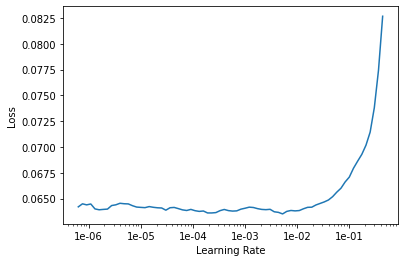

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.063022,0.092375,0.970263,0.518645,07:31
1,0.061147,0.091424,0.970284,0.522197,07:28
2,0.060197,0.091330,0.970237,0.527155,07:34
3,0.058945,0.090542,0.970295,0.531283,07:40
4,0.058446,0.090657,0.970418,0.530117,07:32


In [ ]:
learn.save('phase1-256-rn50')

In [ ]:
learn.export('export_phase1_256.pkl')

**Step 6: Use pretrained weights from Phase1 results and train the model on 128*128 size images**

In [ ]:
##Working on a sample data for train and validation
sample_train_labels2=pd.DataFrame()
sample_train_labels3=pd.DataFrame()
sample_train_labels4=pd.DataFrame()
sample_train_labels1=train_labels[20000:55000].reset_index(drop=True)
sample_train_labels4=train_labels[69000:70000].reset_index(drop=True)
sample_train_labels=pd.concat([sample_train_labels1,sample_train_labels2,sample_train_labels3,sample_train_labels4],ignore_index=True)
sample_valid_labels=validation_labels[1500:5000].reset_index(drop=True)

sample_train_dict=sample_train_labels.to_dict('records')
sample_validation_dict=sample_valid_labels.to_dict('records')

sample_labels=pd.concat([sample_train_labels,sample_valid_labels],ignore_index=True)

sample_labels['filename']='train_data_final_all_v3/'+sample_labels['imageId'].astype(str)+'.jpg'
sample_labels.loc[sample_labels['is_valid']==1,'filename']='validation_data/'+sample_labels['imageId'].astype(str)+'.jpg'
sample_labels['labelId']=sample_labels['labelId'].str.replace(']',"")
sample_labels['labelId']=sample_labels['labelId'].str.replace('[',"")
sample_labels['labelId']=sample_labels['labelId'].str.replace(" ","")
sample_labels['labelId']=sample_labels['labelId'].apply(lambda x:x.replace("'",""))
sample_labels_final=sample_labels[['filename','labelId','is_valid']]

a=[]
for j in sample_labels_final.loc[sample_labels_final['is_valid']==0,'labelId']:
  for k in j.split(','):
    a.append(k)
len(set(a))

228

In [ ]:
#Run multiprocessing to download "train" images
os.mkdir(curr_dir+'train_data_final_all_v3/')

import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
pool = Pool(processes=12)
print('Length of train images is {}'.format(len(sample_train_labels)))
with tqdm(total=len(sample_train_labels)) as progress_bar:
  for _ in pool.imap_unordered(download_train_images,sample_train_dict):
    progress_bar.update(1)

  0%|          | 0/36000 [00:00<?, ?it/s]

Length of train images is 36000


100%|██████████| 36000/36000 [25:50<00:00, 23.22it/s]


In [ ]:
src=(ImageList.from_df(sample_labels_final,path=curr_dir,cols='filename').split_from_df('is_valid').label_from_df(cols='labelId',label_delim=','))
tfms=get_transforms(do_flip=True)

In [ ]:
data=(src.transform(tfms,size=128).databunch(bs=256).normalize(imagenet_stats))

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2,beta=1)
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score])

In [ ]:
learn.load('phase1-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (36000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
62;78;66;147;176;115;214;110;164;9,4;66;171,152;25;19;78;66,122;66;98;153;110;171;20,193;106;153;110;171
Path: /content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5;

Valid: LabelList (3500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
48;19;66;105;153;17;147;20,122;66;171;117;158;154;159;175;204,165;66;45;222;17;59;151,217;17;66;214;171;65;73,127;66;171;17;210;137;20
Path: /content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Ma

In [ ]:
len(data.valid_ds.items),len(data.train_ds.items),learn.data.c,len(learn.data.classes),len(learn.layer_groups)

(3500, 36000, 228, 228, 3)

In [ ]:
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


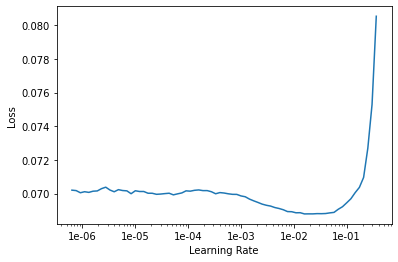

In [ ]:
learn.recorder.plot()

In [ ]:
lr=3e-3
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.066734,0.093205,0.969405,0.514087,28:10
1,0.064738,0.091411,0.969420,0.522586,14:22
2,0.063345,0.090424,0.969683,0.527036,14:19
3,0.062518,0.090795,0.970135,0.527408,14:04


In [ ]:
learn.save('phase2-128-s1-rn50')

**Step 7: Fine tune the model weights for all layer groups on 128*128 size images**

In [ ]:
##Fine tune the model
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


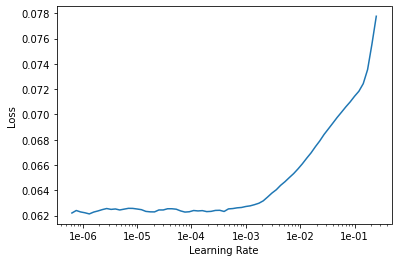

In [ ]:
learn.recorder.plot()

In [ ]:
lr=3e-3
learn.fit_one_cycle(4, slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.061771,0.090208,0.970112,0.529772,14:34
1,0.060611,0.089579,0.970704,0.537406,14:18
2,0.058524,0.088877,0.970898,0.543492,14:56
3,0.057076,0.088310,0.970904,0.545482,14:58


In [ ]:
learn.save('phase2-128-s2-rn50')

In [ ]:
learn.export('export_phase2_128.pkl')

**Step 8: Freeze all layer groups except the last one and update the model weights on 256*256 size images**

In [ ]:
data=(src.transform(tfms,size=256).databunch(bs=64).normalize(imagenet_stats))
learn.data=data

In [ ]:
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


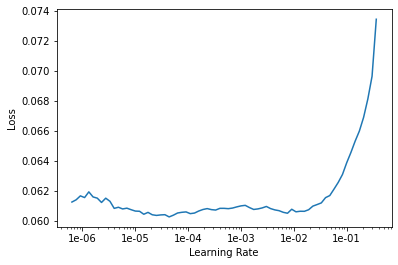

In [ ]:
learn.recorder.plot()

In [ ]:
lr=7e-6
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.060508,0.088721,0.971227,0.543739,23:34
1,0.060875,0.088714,0.971317,0.545046,23:55
2,0.060366,0.088425,0.971213,0.546289,23:52
3,0.060265,0.088314,0.971167,0.545123,24:06


In [ ]:
learn.save('phase2-256-s1-rn50')

**Step 9: Fine tune the model weights for all layer groups on 256*256 size images**

In [ ]:
##Fine tune the model
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


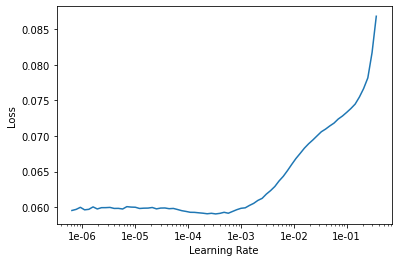

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,slice(5e-5,5e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.060248,0.088150,0.970861,0.546252,24:38
1,0.058719,0.087549,0.971450,0.556214,24:35
2,0.055705,0.085643,0.972605,0.574736,24:17
3,0.053036,0.084965,0.972679,0.578044,24:18


In [ ]:
learn.save('phase2-256-s2-rn50')

In [ ]:
learn.export('export_phase2_256.pkl')

**Step 10: Use pretrained weights from Phase2 results and train the model on 128*128 size images**

In [ ]:
##Working on a sample data for train and validation
sample_train_labels2=pd.DataFrame()
sample_train_labels3=pd.DataFrame()
sample_train_labels4=pd.DataFrame()
sample_train_labels1=train_labels[100000:130000].reset_index(drop=True)
sample_train_labels4=train_labels[165000:170000].reset_index(drop=True)
sample_train_labels2=train_labels[35000:40000].reset_index(drop=True)
sample_train_labels=pd.concat([sample_train_labels1,sample_train_labels2,sample_train_labels3,sample_train_labels4],ignore_index=True)
sample_valid_labels=validation_labels[5000:].reset_index(drop=True)

sample_train_dict=sample_train_labels.to_dict('records')
sample_validation_dict=sample_valid_labels.to_dict('records')

sample_labels=pd.concat([sample_train_labels,sample_valid_labels],ignore_index=True)

sample_labels['filename']='train_data_final_all_v4/'+sample_labels['imageId'].astype(str)+'.jpg'
sample_labels.loc[sample_labels['is_valid']==1,'filename']='validation_data/'+sample_labels['imageId'].astype(str)+'.jpg'
sample_labels['labelId']=sample_labels['labelId'].str.replace(']',"")
sample_labels['labelId']=sample_labels['labelId'].str.replace('[',"")
sample_labels['labelId']=sample_labels['labelId'].str.replace(" ","")
sample_labels['labelId']=sample_labels['labelId'].apply(lambda x:x.replace("'",""))
sample_labels_final=sample_labels[['filename','labelId','is_valid']]

a=[]
for j in sample_labels_final.loc[sample_labels_final['is_valid']==0,'labelId']:
  for k in j.split(','):
    a.append(k)
len(set(a))

228

In [ ]:
#Run multiprocessing to download "train" images
os.mkdir(curr_dir+'train_data_final_all_v4/')

import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm
pool = Pool(processes=12)
print('Length of train images is {}'.format(len(sample_train_labels)))
with tqdm(total=len(sample_train_labels)) as progress_bar:
  for _ in pool.imap_unordered(download_train_images,sample_train_dict):
    progress_bar.update(1)

  0%|          | 0/40000 [00:00<?, ?it/s]

Length of train images is 40000


100%|██████████| 40000/40000 [20:45<00:00, 32.12it/s]


In [ ]:
src=(ImageList.from_df(sample_labels_final,path=curr_dir,cols='filename').split_from_df('is_valid').label_from_df(cols='labelId',label_delim=','))
tfms=get_transforms(do_flip=True)

In [ ]:
data=(src.transform(tfms,size=128).databunch(bs=256).normalize(imagenet_stats))

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2,beta=1)
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score])

In [ ]:
learn.load('phase2-256-s2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
187;19;17;148;106;176,66;97;116;105;20,71;131;66;186;154;171;133,193;113;53;153;171,201;19;78;131;17;222;66;53
Path: /content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5;

Valid: LabelList (4897 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
17;66;222;164;137;181;184,193;66;171;78;148;7;191;184,36;66;164;222;19;153;53;181;184,26;106;105;14;78;49;53;115;143;209,89;17;66;98;110
Path: /content/gdrive/My Drive/Kaggle/iMaterialist_Challenge_FGVC5;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
   

In [ ]:
len(data.valid_ds.items),len(data.train_ds.items),learn.data.c,len(learn.data.classes),len(learn.layer_groups)

(4897, 40000, 228, 228, 3)

In [ ]:
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


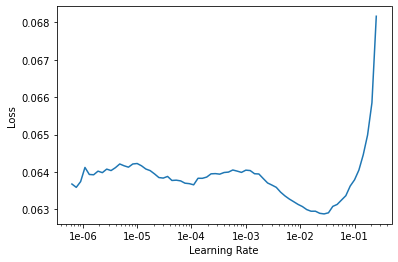

In [ ]:
learn.recorder.plot()

In [ ]:
lr=4e-3
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.060889,0.089893,0.970073,0.547392,27:17
1,0.059303,0.089957,0.970769,0.551040,15:53
2,0.058304,0.088568,0.970390,0.553367,16:03
3,0.057394,0.088677,0.970667,0.555787,15:51


In [ ]:
learn.save('phase3-128-s1-rn50')

**Step 11:Fine tune the model weights for all layer groups on 128*128 size images**

In [ ]:
##Fine tune the model
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


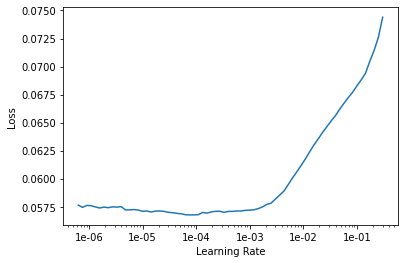

In [ ]:
learn.recorder.plot()

In [ ]:
lr=4e-3
learn.fit_one_cycle(4, slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.057056,0.089033,0.970499,0.554822,15:52
1,0.056161,0.089067,0.970904,0.558254,16:04
2,0.054787,0.088739,0.970665,0.560829,16:14
3,0.053294,0.088424,0.970636,0.562300,15:49


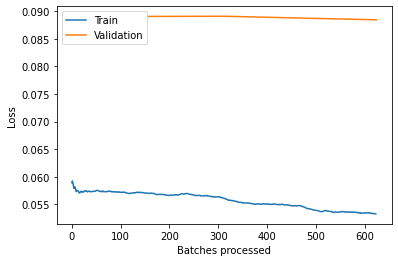

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('phase3-128-s2-rn50')

In [ ]:
learn.export('export_phase3_128.pkl')

**Step 12: Freeze all layer groups except the last one and update the model weights on 256*256 size images**

In [ ]:
data=(src.transform(tfms,size=256).databunch(bs=64).normalize(imagenet_stats))
learn.data=data

In [ ]:
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


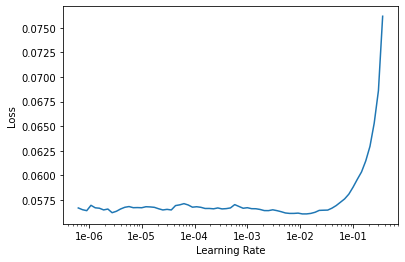

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-3
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.054874,0.086711,0.971703,0.579626,26:18
1,0.054558,0.086388,0.972001,0.583462,26:12
2,0.053397,0.086704,0.971819,0.581866,25:48
3,0.053510,0.086602,0.972069,0.583924,26:11
4,0.053235,0.086969,0.972201,0.584300,26:24


In [ ]:
learn.save('phase4-256-s1-rn50')

**Step 13: Fine tune the model weights for all layer groups on 256*256 size images**

In [ ]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


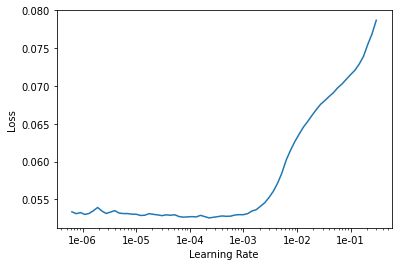

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.052925,0.086336,0.972095,0.583616,27:29
1,0.053245,0.086656,0.971920,0.582941,27:41
2,0.052243,0.086486,0.971790,0.582327,27:58
3,0.050369,0.087247,0.972056,0.584089,28:09
4,0.048862,0.087164,0.972018,0.584678,28:28


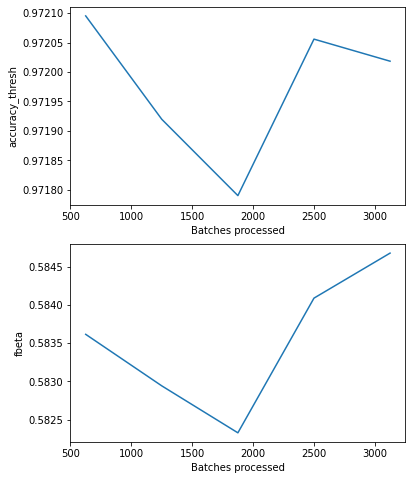

In [ ]:
learn.recorder.plot_metrics()

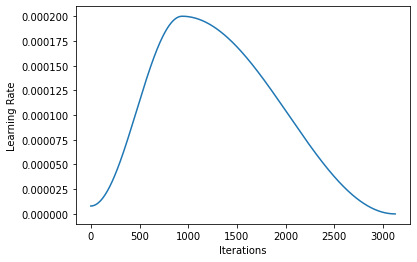

In [ ]:
learn.recorder.plot_lr()

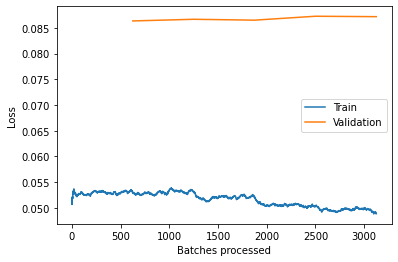

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('phase4-256-s2-rn50')

In [ ]:
learn.export('export_phase3_256.pkl')

**Step 14: Inference time predictions on public test data**

In [ ]:
test_labels=pd.read_csv(curr_dir+'test_labels_all.csv')

test_labels['imageId1']='test_'+test_labels['imageId'].astype(str)
test_labels.drop(columns='imageId',inplace=True)
test_labels.rename(columns={'imageId1':'imageId'},inplace=True)

test_dict=test_labels.to_dict('records')
test_labels['filename']='test_data/'+test_labels['imageId'].astype(str)+'.jpg'
test_labels=test_labels[['filename','url']]

In [ ]:
test=ImageList.from_df(test_labels,path=curr_dir,cols='filename')
learn = load_learner(curr_dir, 'export_v4_256_s2.pkl',test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh=0.18
learn.data.classes_new=[re.sub('\ |\[|\]','',i) for i in learn.data.classes]
labelled_preds = [' '.join([(learn.data.classes_new[i].replace("'",'')) for i,p in enumerate(pred) if p > thresh]) for pred in preds]
labelled_preds1=[' '.join([(k) for k in set(i.split(' '))]) for i in labelled_preds]

f_names=[str(i).rsplit('/')[-1] for i in learn.data.test_ds.items]
fnames=[i.rsplit('_')[1][:-4] for i in f_names]

In [ ]:
x1=dict(zip(fnames,labelled_preds1))
df=pd.DataFrame(list(x1.items()),columns=['image_id','label_id'])
df.to_csv(curr_dir+'test_output_final_all_v4_1.csv',index=False)  ##Yieled an private test fbeta score of 0.58014 positioning 38 on the Leaderboard

**Step 15: Experiment with different threshold values for differnet classes**

In [ ]:
validation_labels_final=all_labels_final.loc[all_labels_final['is_valid']==1].reset_index(drop=True)

In [ ]:
valid_data=ImageList.from_df(validation_labels_final,path=curr_dir,cols='filename')
learn = load_learner(curr_dir, 'export_phase3_256.pkl',test=valid_data)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
arr_valid_pred_all=np.array(preds)
arr_valid_y_all=np.zeros((len(validation_labels),228))
for i in range(len(arr_valid_y_all)):
  for j in ast.literal_eval(validation_labels.iloc[i]['labelId']):
    arr_valid_y_all[i][int(j)-1]=1

In [ ]:
n_classes=228
def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
  def mf(x):
    p2 = np.zeros_like(p)
    for i in range(n_classes):
      p2[:, i] = (p[:, i] > x[i]).astype(np.int)
    score = fbeta_score(y, p2, beta=1, average='samples')
    return score

  x = [0.2]*n_classes
  for i in range(n_classes):
    best_i2 = 0
    best_score = 0
    for i2 in range(resolution):
      i2 /= resolution
      x[i] = i2
      score = mf(x)
      if score > best_score:
        best_i2 = i2
        best_score = score
    x[i] = best_i2
    if verbose:
      print(i, best_i2, best_score)

  return x

In [ ]:
class_best_thresholds=optimise_f2_thresholds(arr_valid_y_all,arr_valid_pred_all)

0 0.01 0.030282589864902384
1 0.0 0.03154767056584857
2 0.39 0.03157342041792882
3 0.99 0.03158890093507651
4 0.0 0.032141150608869413
5 0.7 0.032146772257492726
6 0.0 0.03263776248786599
7 0.99 0.03341449047353963
8 0.0 0.03522819105527791
9 0.01 0.03522819105527791
10 0.01 0.03522819105527791
11 0.83 0.03523607924527613
12 0.47 0.03524640193469968
13 0.0 0.03897989479876768
14 0.01 0.039269567825963976
15 0.14 0.039269567825963976
16 0.0 0.08027903063792646
17 0.0 0.0814391479940548
18 0.0 0.09183365650639672
19 0.0 0.10345965063759353
20 0.38 0.10347401538633785
21 0.2 0.10347401538633785
22 0.03 0.10347401538633785
23 0.08 0.10347401538633785
24 0.87 0.103477795647728
25 0.55 0.10348800688396928
26 0.51 0.10364437648003087
27 0.1 0.10364437648003087
28 0.02 0.10364437648003087
29 0.01 0.10364651822222344
30 0.55 0.10365634562814363
31 0.33 0.103657543739441
32 0.59 0.10377055574449841
33 0.01 0.10377055574449841
34 0.35 0.10377585016054275
35 0.0 0.10454899365026207
36 0.79 0.10467

In [ ]:
class_best_thresholds_final=[i if i >0.1 else 0.1 for i in class_best_thresholds]
class_best_thresholds_final1=[i if i <0.2 else 0.2 for i in class_best_thresholds_final]

In [ ]:
##Testing Outputs based on new thresholds

In [ ]:
learn.data.classes_new=[re.sub('\ |\[|\]','',i) for i in learn.data.classes]
labelled_preds = [' '.join([(learn.data.classes_new[i].replace("'",'')) for i,p in enumerate(pred) if p > class_best_thresholds_final1[i]]) for pred in preds]
labelled_preds1=[' '.join([(k) for k in set(i.split(' '))]) for i in labelled_preds]

In [ ]:
f_names=[str(i).rsplit('/')[-1] for i in learn.data.test_ds.items]
fnames=[i.rsplit('_')[1][:-4] for i in f_names]

x1=dict(zip(fnames,labelled_preds1))
df=pd.DataFrame(list(x1.items()),columns=['image_id','label_id'])
df.to_csv(curr_dir+'test_output_final_all_v3_th_adj2.csv',index=False)

In [ ]:
###Optimizing for thresholds didn't work and is unaffective